
Epoch 13/100: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Epoch [13/100], Train Loss: 1.0003, Valid Loss: 0.9996
Early stopping triggered.


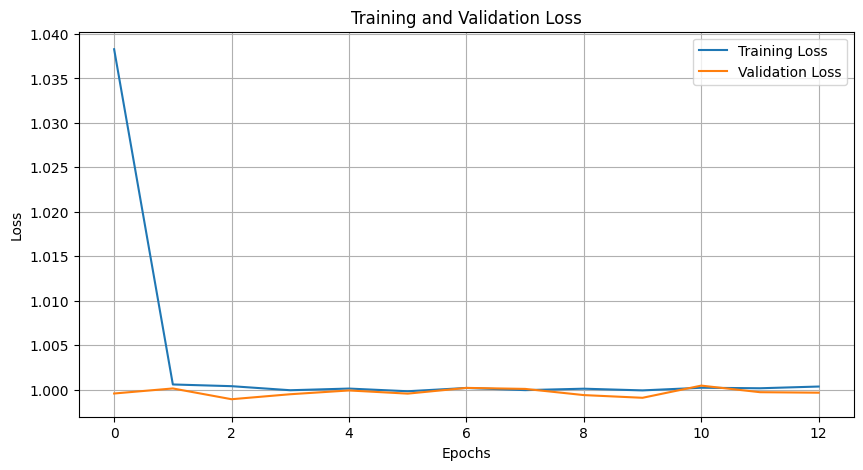

Saved final model.
Training 3D Classifier...



Epoch 1/50: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Epoch [1/50], Train Loss: 2.4795, Train Acc: 50.00%, Valid Acc: 50.00%
Saved best classifier checkpoint.



Epoch 2/50: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


Epoch [2/50], Train Loss: 1.2339, Train Acc: 45.50%, Valid Acc: 50.00%



Epoch 3/50: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Epoch [3/50], Train Loss: 0.8179, Train Acc: 52.50%, Valid Acc: 50.00%



Epoch 4/50: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Epoch [4/50], Train Loss: 0.8120, Train Acc: 40.50%, Valid Acc: 50.00%



Epoch 5/50: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


Epoch [5/50], Train Loss: 0.6918, Train Acc: 52.50%, Valid Acc: 50.00%



Epoch 6/50: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Epoch [6/50], Train Loss: 0.6988, Train Acc: 54.50%, Valid Acc: 50.00%



Epoch 7/50: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


Epoch [7/50], Train Loss: 0.7047, Train Acc: 44.00%, Valid Acc: 50.00%



Epoch 8/50: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Epoch [8/50], Train Loss: 0.6935, Train Acc: 50.00%, Valid Acc: 50.00%



Epoch 9/50: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Epoch [9/50], Train Loss: 0.6935, Train Acc: 50.00%, Valid Acc: 50.00%



Epoch 10/50: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]


Epoch [10/50], Train Loss: 0.6939, Train Acc: 50.00%, Valid Acc: 50.00%



Epoch 11/50: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


Epoch [11/50], Train Loss: 0.6931, Train Acc: 50.00%, Valid Acc: 50.00%
Early stopping triggered.


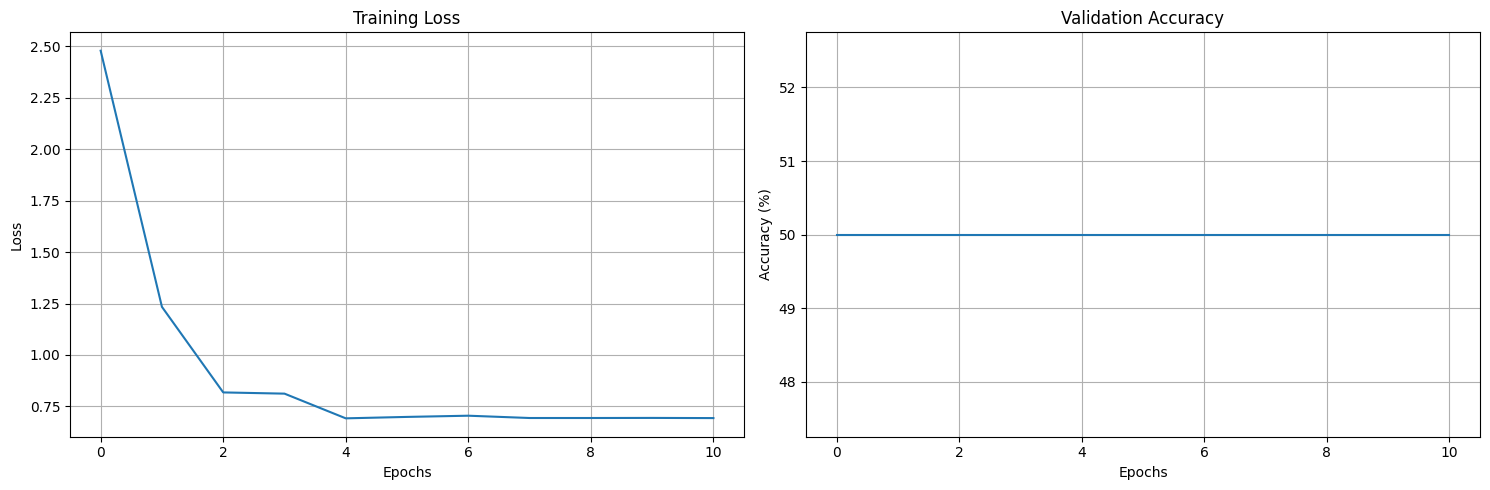

Saved final classifier.
Evaluating classifier on test data...



Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s, acc=50.00%]


Test Accuracy: 50.00%


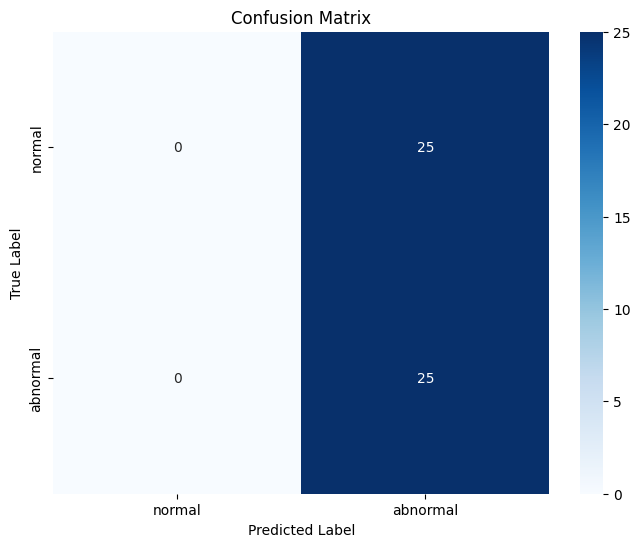

Visualizing test reconstructions...


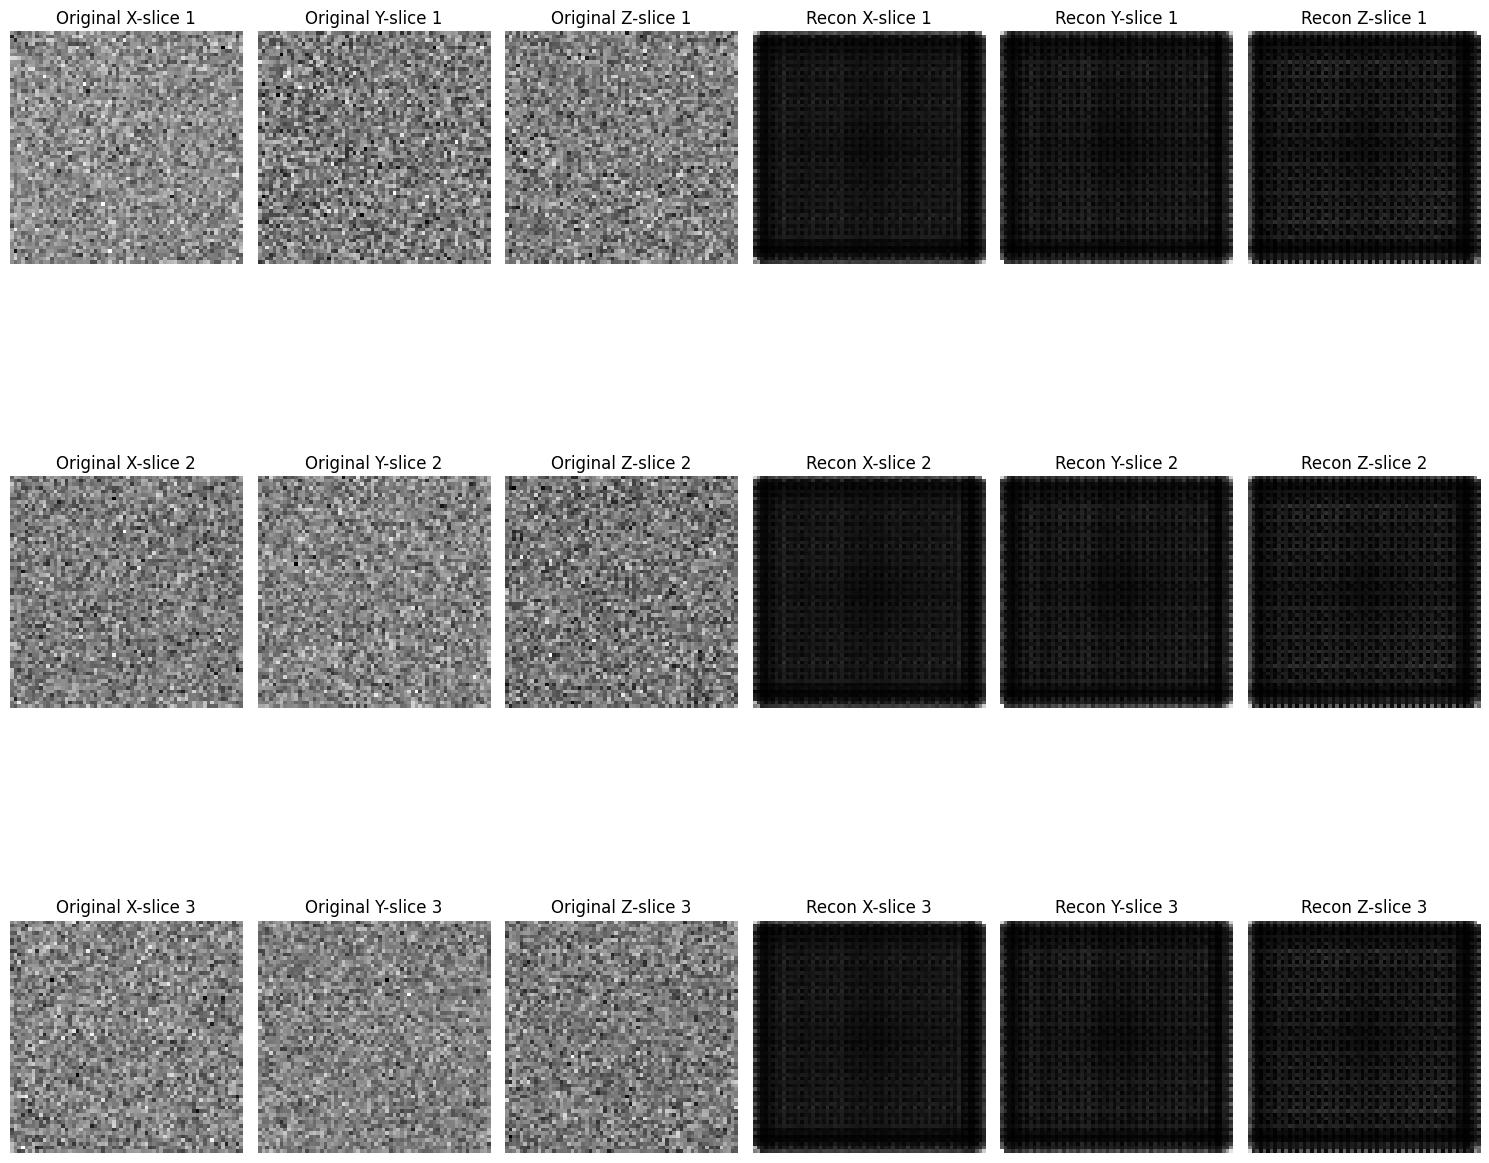

3D Autoencoder and Classifier training complete!


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import nibabel as nib  # For handling 3D medical images
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

# Custom 3D Dataset class for handling volumetric data
class VolumeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}

        # Find all classes (directories)
        classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        classes.sort()

        # Assign class indices
        for idx, cls in enumerate(classes):
            self.class_to_idx[cls] = idx

        # Collect all samples
        for cls in classes:
            class_dir = os.path.join(root_dir, cls)
            for file in os.listdir(class_dir):
                if file.endswith('.nii') or file.endswith('.nii.gz'):  # Common 3D medical image formats
                    self.samples.append((os.path.join(class_dir, file), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load 3D volume
        volume = nib.load(file_path).get_fdata()

        # Resize to 64x64x64 (or desired size)
        # In practice, you'd use a proper 3D resize function
        # This is a simplified example
        volume = self.resize_volume(volume, (64, 64, 64))

        # Convert to tensor
        volume_tensor = torch.from_numpy(volume).float()

        # Add channel dimension (1 channel for grayscale)
        volume_tensor = volume_tensor.unsqueeze(0)

        # Apply transformations if any
        if self.transform:
            volume_tensor = self.transform(volume_tensor)

        return volume_tensor, label

    def resize_volume(self, volume, target_shape):
        # Simple resize by slicing or padding (for example purposes)
        # In practice, use proper interpolation methods
        resized = np.zeros(target_shape)

        # Get current shape
        current_shape = volume.shape

        # Compute dimensions to copy
        x_dim = min(current_shape[0], target_shape[0])
        y_dim = min(current_shape[1], target_shape[1])
        z_dim = min(current_shape[2], target_shape[2])

        # Copy data
        resized[:x_dim, :y_dim, :z_dim] = volume[:x_dim, :y_dim, :z_dim]

        # Normalize to [0, 1]
        if resized.max() > 0:
            resized = (resized - resized.min()) / (resized.max() - resized.min())

        return resized

# 3D transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x - 0.5) / 0.5)  # Normalize to [-1, 1]
])

# Load dataset
# For demonstration purposes, we'll simulate data loading
# In practice, replace these paths with your 3D volume data paths
try:
    # Attempt to load actual data if available
    train_dataset = VolumeDataset(root='/content/AIDER-classification-1/train', transform=transform)
    valid_dataset = VolumeDataset(root='/content/AIDER-classification-1/valid', transform=transform)
    test_dataset = VolumeDataset(root='/content/AIDER-classification-1/test', transform=transform)

    print("Loaded 3D datasets")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(valid_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Class mapping: {train_dataset.class_to_idx}")

except Exception as e:
    print(f"Warning: {e}")
    print("Using dummy data for demonstration")

    # Create dummy datasets for demonstration
    class DummyVolumeDataset(Dataset):
        def __init__(self, num_samples=100, size=64, classes=2):
            self.num_samples = num_samples
            self.size = size
            self.classes = classes
            self.class_to_idx = {'normal': 0, 'abnormal': 1}

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            # Generate random volume
            volume = torch.randn(1, self.size, self.size, self.size)
            label = idx % self.classes
            return volume, label

    train_dataset = DummyVolumeDataset(num_samples=200)
    valid_dataset = DummyVolumeDataset(num_samples=50)
    test_dataset = DummyVolumeDataset(num_samples=50)

    print("Using dummy 3D datasets for demonstration")
    print(f"Class mapping: {train_dataset.class_to_idx}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3D Residual Block
class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock3D, self).__init__()

        # First convolution layer
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.LeakyReLU(0.2)

        # Second convolution layer
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # If the dimensions don't match, we use a 1x1x1 convolution to match both channels and spatial dimensions
        self.skip_connection = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0) if in_channels != out_channels or stride != 1 else nn.Identity()

    def forward(self, x):
        identity = self.skip_connection(x)  # Adjust identity dimensions if needed

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Add the skip connection (residual connection)
        out = self.relu(out)

        return out

# 3D Convolutional Autoencoder
class ConvAutoencoder3D(nn.Module):
    def __init__(self, input_channels=1):
        super(ConvAutoencoder3D, self).__init__()

        # Encoder with Residual Blocks
        self.encoder = nn.Sequential(
            ResidualBlock3D(input_channels, 32, kernel_size=7, stride=2, padding=3),  # Output: (32, 32, 32, 32)
            ResidualBlock3D(32, 64, kernel_size=7, stride=2, padding=3),              # Output: (64, 16, 16, 16)
            ResidualBlock3D(64, 128, kernel_size=7, stride=2, padding=3),             # Output: (128, 8, 8, 8)
            ResidualBlock3D(128, 256, kernel_size=3, stride=2, padding=1),            # Output: (256, 4, 4, 4)
        )

        # Decoder with 3D Transposed Convolutions
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (128, 8, 8, 8)
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose3d(128, 64, kernel_size=7, stride=2, padding=3, output_padding=1),  # Output: (64, 16, 16, 16)
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose3d(64, 32, kernel_size=7, stride=2, padding=3, output_padding=1),  # Output: (32, 32, 32, 32)
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose3d(32, input_channels, kernel_size=7, stride=2, padding=3, output_padding=1),  # Output: (1, 64, 64, 64)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = ConvAutoencoder3D()
model.to(device)
print(model)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function with visualization - MODIFIED WITH SINGLE PROGRESS BAR
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=150, patience=10, device=device):
    model.to(device)
    best_valid_loss = float('inf')
    patience_counter = 0

    train_losses = []
    valid_losses = []

    # For visualization during training
    example_data = None
    example_output = None

    for epoch in range(epochs):
        # Create a single progress bar for the epoch
        pbar = tqdm(total=len(train_loader) + len(valid_loader),
                    desc=f"Epoch {epoch+1}/{epochs}",
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

        # Training phase
        model.train()
        train_loss = 0

        for data, _ in train_loader:  # We ignore labels
            data = data.to(device)

            # Save first batch for visualization
            if epoch == 0 and example_data is None:
                example_data = data[0:1].clone()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, data)  # Reconstruction loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Update progress bar
            pbar.set_postfix(phase="Train", loss=f"{loss.item():.4f}")
            pbar.update(1)
            time.sleep(0.01)  # Small delay for visualization

        # Validation phase
        model.eval()
        valid_loss = 0

        with torch.no_grad():
            for data, _ in valid_loader:
                data = data.to(device)
                outputs = model(data)
                loss = criterion(outputs, data)
                valid_loss += loss.item()

                # Save last batch for visualization
                example_output = outputs[0:1].clone()

                # Update progress bar
                pbar.set_postfix(phase="Valid", loss=f"{loss.item():.4f}")
                pbar.update(1)
                time.sleep(0.01)  # Small delay for visualization

        # Close the progress bar for this epoch
        pbar.close()

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

        # Visualize reconstructions periodically
        if (epoch + 1) % 10 == 0 and example_data is not None and example_output is not None:
            visualize_3d_reconstruction(example_data, example_output, epoch + 1)

        # Early Stopping Check
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_autoencoder3d.pth")
            print("Saved best model checkpoint.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')
    plt.show()

    return train_losses, valid_losses

# Function to visualize 3D volumes as 2D slices
def visualize_3d_reconstruction(original, reconstructed, epoch):
    # Move tensors to CPU and convert to numpy
    original = original.cpu().detach().numpy()[0, 0]  # Remove batch and channel dimensions
    reconstructed = reconstructed.cpu().detach().numpy()[0, 0]  # Remove batch and channel dimensions

    # Plot middle slices in each dimension
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    # X-dimension middle slice
    x_mid = original.shape[0] // 2
    axes[0, 0].imshow(original[x_mid, :, :], cmap='gray')
    axes[0, 0].set_title('Original - X Middle Slice')
    axes[0, 1].imshow(reconstructed[x_mid, :, :], cmap='gray')
    axes[0, 1].set_title('Reconstructed - X Middle Slice')

    # Y-dimension middle slice
    y_mid = original.shape[1] // 2
    axes[1, 0].imshow(original[:, y_mid, :], cmap='gray')
    axes[1, 0].set_title('Original - Y Middle Slice')
    axes[1, 1].imshow(reconstructed[:, y_mid, :], cmap='gray')
    axes[1, 1].set_title('Reconstructed - Y Middle Slice')

    # Z-dimension middle slice
    z_mid = original.shape[2] // 2
    axes[2, 0].imshow(original[:, :, z_mid], cmap='gray')
    axes[2, 0].set_title('Original - Z Middle Slice')
    axes[2, 1].imshow(reconstructed[:, :, z_mid], cmap='gray')
    axes[2, 1].set_title('Reconstructed - Z Middle Slice')

    plt.tight_layout()
    plt.savefig(f'reconstruction_epoch_{epoch}.png')
    plt.close()

# Train the autoencoder
print("Training 3D Autoencoder...")
train_losses, valid_losses = train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100)

# Save the final model
torch.save(model.state_dict(), "autoencoder3d.pth")
print("Saved final model.")

# 3D Classifier using the trained encoder
class BinaryClassifier3D(nn.Module):
    def __init__(self, pretrained_encoder):
        super(BinaryClassifier3D, self).__init__()
        self.encoder = pretrained_encoder  # Use pretrained encoder

        # Freeze encoder parameters (optional)
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4 * 4, 512),  # Adjust based on encoder output size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Output: 2 classes (Normal, Abnormal)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Instantiate classifier with pretrained encoder
classifier = BinaryClassifier3D(model.encoder)
classifier.to(device)

# Define loss and optimizer for classifier
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=0.0005)

# Train classifier - MODIFIED WITH SINGLE PROGRESS BAR
def train_classifier(model, train_loader, valid_loader, criterion, optimizer, epochs=50, patience=10, device=device):
    model.to(device)
    best_valid_acc = 0
    patience_counter = 0

    train_losses = []
    valid_accs = []

    for epoch in range(epochs):
        # Single progress bar for the entire epoch
        pbar = tqdm(total=len(train_loader) + len(valid_loader),
                    desc=f"Epoch {epoch+1}/{epochs}",
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

        # Training phase
        model.train()
        train_loss = 0
        correct, total = 0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix(phase="Train", loss=f"{loss.item():.4f}", acc=f"{100 * correct / total:.2f}%")
            pbar.update(1)
            time.sleep(0.01)  # Small delay for visualization

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for data, labels in valid_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Update progress bar
                pbar.set_postfix(phase="Valid", acc=f"{100 * val_correct / val_total:.2f}%")
                pbar.update(1)
                time.sleep(0.01)  # Small delay for visualization

        # Close the progress bar for this epoch
        pbar.close()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = 100 * correct / total
        avg_valid_acc = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        valid_accs.append(avg_valid_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, Valid Acc: {avg_valid_acc:.2f}%")

        # Early Stopping Check based on accuracy
        if avg_valid_acc > best_valid_acc:
            best_valid_acc = avg_valid_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_classifier3d.pth")
            print("Saved best classifier checkpoint.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(valid_accs)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('classifier_training.png')
    plt.show()

    return train_losses, valid_accs

# Train classifier
print("Training 3D Classifier...")
classifier_train_losses, classifier_valid_accs = train_classifier(classifier, train_loader, valid_loader, criterion_cls, optimizer_cls, epochs=50)

# Save the classifier
torch.save(classifier.state_dict(), "classifier3d.pth")
print("Saved final classifier.")

# Evaluate model - MODIFIED WITH SINGLE PROGRESS BAR
def evaluate_model(model, test_loader, device=device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    # Single progress bar for evaluation
    with tqdm(total=len(test_loader), desc="Evaluating") as pbar:
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update progress bar
                pbar.set_postfix(acc=f"{100 * correct / total:.2f}%")
                pbar.update(1)
                time.sleep(0.01)  # Small delay for visualization

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(test_dataset.class_to_idx.keys()),
                yticklabels=list(test_dataset.class_to_idx.keys()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return accuracy, cm

# Evaluate the classifier
print("Evaluating classifier on test data...")
test_accuracy, test_cm = evaluate_model(classifier, test_loader)

# Visualize sample reconstructions from test set
def visualize_test_reconstructions(model, test_loader, num_samples=3, device=device):
    model.eval()

    # Get a batch of test data
    test_iter = iter(test_loader)
    test_data, test_labels = next(test_iter)
    test_data = test_data[:num_samples].to(device)

    # Get reconstructions
    with torch.no_grad():
        reconstructions = model(test_data)

    fig = plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Original 3D volume - middle slices
        original = test_data[i, 0].cpu().numpy()
        recon = reconstructions[i, 0].cpu().numpy()

        # Get middle slices
        x_mid = original.shape[0] // 2
        y_mid = original.shape[1] // 2
        z_mid = original.shape[2] // 2

        # Plot original and reconstructed slices
        ax1 = fig.add_subplot(num_samples, 6, i*6 + 1)
        ax1.imshow(original[x_mid, :, :], cmap='gray')
        ax1.set_title(f'Original X-slice {i+1}')
        ax1.axis('off')

        ax2 = fig.add_subplot(num_samples, 6, i*6 + 2)
        ax2.imshow(original[:, y_mid, :], cmap='gray')
        ax2.set_title(f'Original Y-slice {i+1}')
        ax2.axis('off')

        ax3 = fig.add_subplot(num_samples, 6, i*6 + 3)
        ax3.imshow(original[:, :, z_mid], cmap='gray')
        ax3.set_title(f'Original Z-slice {i+1}')
        ax3.axis('off')

        ax4 = fig.add_subplot(num_samples, 6, i*6 + 4)
        ax4.imshow(recon[x_mid, :, :], cmap='gray')
        ax4.set_title(f'Recon X-slice {i+1}')
        ax4.axis('off')

        ax5 = fig.add_subplot(num_samples, 6, i*6 + 5)
        ax5.imshow(recon[:, y_mid, :], cmap='gray')
        ax5.set_title(f'Recon Y-slice {i+1}')
        ax5.axis('off')

        ax6 = fig.add_subplot(num_samples, 6, i*6 + 6)
        ax6.imshow(recon[:, :, z_mid], cmap='gray')
        ax6.set_title(f'Recon Z-slice {i+1}')
        ax6.axis('off')

    plt.tight_layout()
    plt.savefig('test_reconstructions.png')
    plt.show()

# Visualize some test reconstructions
print("Visualizing test reconstructions...")
visualize_test_reconstructions(model, test_loader, num_samples=3)

print("3D Autoencoder and Classifier training complete!")